# **Stock Prediction for IBM-stock-price-dataset**

## Importing libraries and mounting data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import datetime as dt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [2]:
data = pd.read_csv('/content/drive/MyDrive/IOP/IBM_Stock_Price_Data.csv',index_col='date',parse_dates=True)
data.head(5)

,S. No.,open,high,low,close,adjusted close,volume,dividend amount,split cf
date,,,,,,,,,
2021-11-26,0,115.00,116.335,114.56,115.81,115.81,3322012,0.0,1.0
2021-11-24,1,116.16,117.270,116.08,116.73,116.73,3220802,0.0,1.0
2021-11-23,2,116.79,117.940,116.04,116.79,116.79,4914995,0.0,1.0
2021-11-22,3,116.00,118.810,115.19,116.47,116.47,6417218,0.0,1.0
2021-11-19,4,116.49,116.560,115.27,116.05,116.05,5384548,0.0,1.0


### General Description of dataset

In [ ]:
data.describe

<bound method NDFrame.describe of             S. No.    open     high     low   close  adjusted close    volume  \
date                                                                            
2021-11-26       0  115.00  116.335  114.56  115.81      115.810000   3322012   
2021-11-24       1  116.16  117.270  116.08  116.73      116.730000   3220802   
2021-11-23       2  116.79  117.940  116.04  116.79      116.790000   4914995   
2021-11-22       3  116.00  118.810  115.19  116.47      116.470000   6417218   
2021-11-19       4  116.49  116.560  115.27  116.05      116.050000   5384548   
...            ...     ...      ...     ...     ...             ...       ...   
1999-11-05    5550   92.75   92.940   90.19   90.25       52.226608  13737600   
1999-11-04    5551   94.44   94.440   90.00   91.56       52.984689  16697600   
1999-11-03    5552   95.87   95.940   93.50   94.37       54.610803  10369100   
1999-11-02    5553   96.75   96.810   93.69   94.81       54.865426  111054

###Plots of features of Dataset vs Date

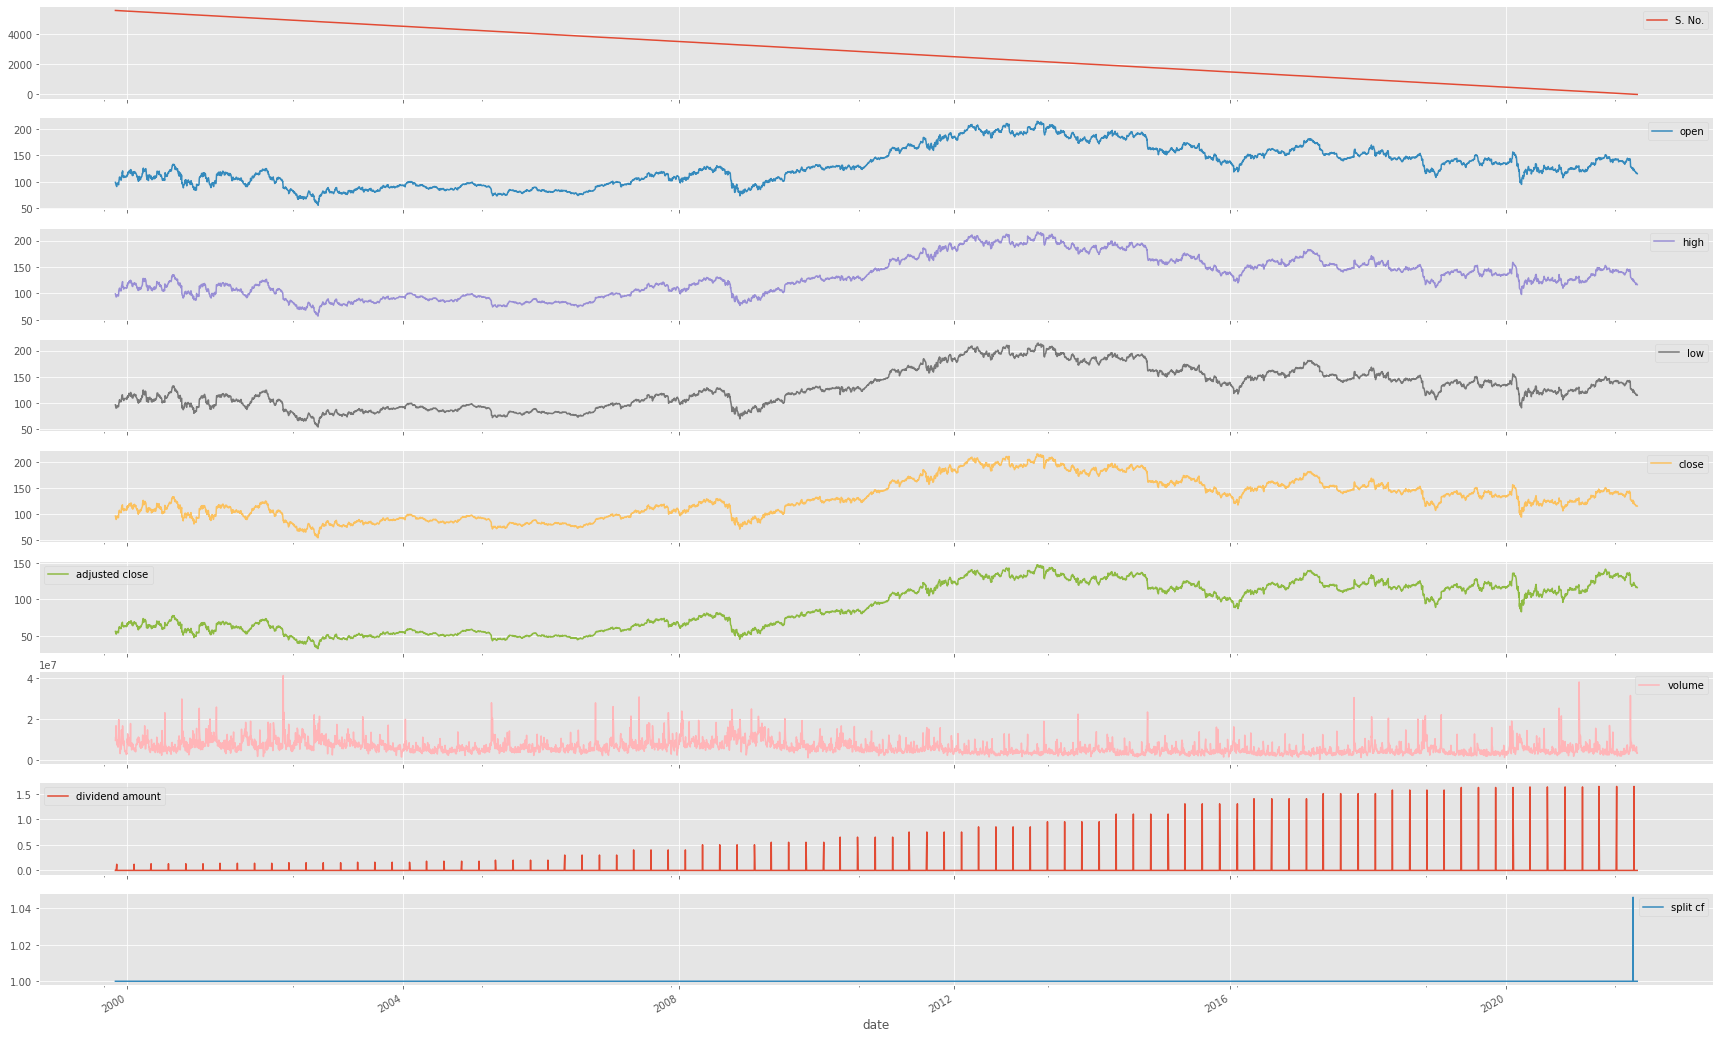

In [ ]:
ax = data.plot(figsize=(30,20),subplots = 'True')

## Input for window width of latest stock features to predict next day opening stock price 

In [3]:
window_width = 40
train_test_partition = 1500

##Rolling average figure to judge if window width is accurate 

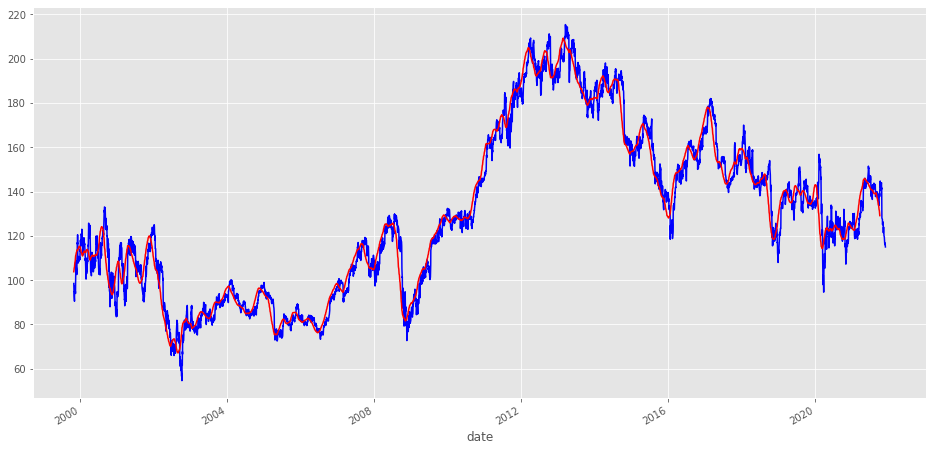

In [ ]:
data['open'].plot(figsize=(16,8), color = "blue")
data.rolling(window = window_width).mean()['close'].plot(color = "red")

##Creating Train and Test dataset from original stock-price-dataset 

In [4]:
from sklearn.preprocessing import MinMaxScaler
train_set = data.iloc[:train_test_partition, 1:2].values
test_set = data.iloc[train_test_partition:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
testing_set_scaled = sc.transform(test_set)
test_data_size = len(test_set)
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(window_width, train_test_partition):
    X_train.append(training_set_scaled[i-window_width:i, 0])
    y_train.append(training_set_scaled[i, 0])
for i in range(window_width, test_data_size):
    X_test.append(testing_set_scaled[i-window_width:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## **Applying XG-Boost technique to training dataset**

### Fit over training data

In [ ]:
import xgboost as xg
xgb = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 50)
xgb.fit(X_train.reshape(-1,window_width), y_train)

XGBRegressor(n_estimators=50, objective='reg:squarederror')

###Evaluate predictions for testing data

In [ ]:
y_test_org = sc.inverse_transform(y_test.reshape(-1,1))
y_test_org = y_test_org.reshape([-1,1])
predict_train = xgb.predict(X_train.reshape(-1,window_width))
predicted_stock_price = xgb.predict(X_test.reshape(-1,window_width))
predict_train = sc.inverse_transform(predict_train.reshape(-1,1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1,1))

###Actual vs Predictied Stock Price plot for XG-Boost

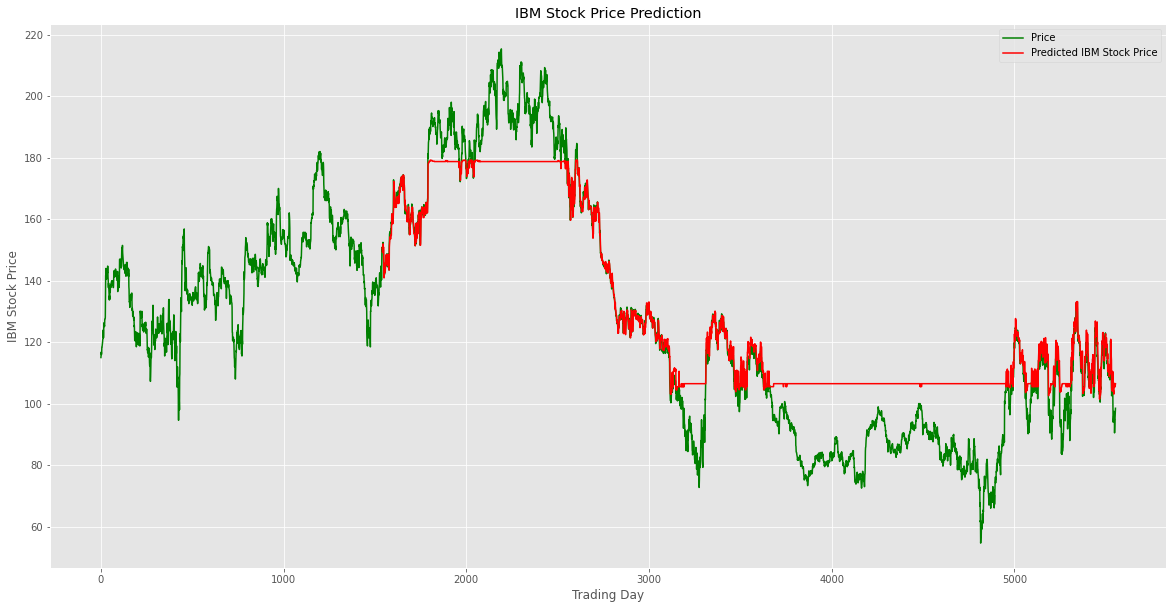

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.iloc[:,1:2].values, color = 'green', label = 'Price')
plt.plot(np.arange(train_test_partition + window_width, len(data), 1),predicted_stock_price, color = 'red', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

###Mean Squared Error for XG-Boost

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test_org,predicted_stock_price)

237.81739529790104

###R2 Score for XG-Boost 

In [ ]:
from sklearn.metrics import r2_score
r2_score(predicted_stock_price,y_test_org)

0.7220412199430315

## **Applying Long-Short-Term-Memory Recurrent Neural Networks DL technique on training dataset**

###Import LSTM and ANN layers from Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras import layers
from keras import backend as K
import random
random.seed(1)

###Design the Neural Network Architecture

In [ ]:
Regressor = Sequential()
Regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
Regressor.add(Dropout(0.2))
Regressor.add(LSTM(units = 50, return_sequences = True))
Regressor.add(Dropout(0.2))
Regressor.add(LSTM(units = 50, return_sequences = True))
Regressor.add(Dropout(0.2))
Regressor.add(LSTM(64, return_sequences=False))
Regressor.add(Dropout(0.2))
Regressor.add(Dense(1,activation='linear'))

In [ ]:
Regressor.compile(optimizer='Adam', loss = 'mean_squared_error')

###Summary of Neural Network Architecture

In [ ]:
Regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 40, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                2

###Train the dataset on designed neural network

In [ ]:
model = Regressor.fit(X_train, y_train, epochs = 15, batch_size = 64, validation_data = [X_test, y_test])

Epoch 1/15
23/23 [==============================] - 12s 176ms/step - loss: 0.0659 - val_loss: 0.0440
Epoch 2/15
23/23 [==============================] - 2s 91ms/step - loss: 0.0138 - val_loss: 0.0375
Epoch 3/15
23/23 [==============================] - 2s 90ms/step - loss: 0.0105 - val_loss: 0.0162
Epoch 4/15
23/23 [==============================] - 2s 90ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 5/15
23/23 [==============================] - 2s 90ms/step - loss: 0.0084 - val_loss: 0.0120
Epoch 6/15
23/23 [==============================] - 2s 91ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 7/15
23/23 [==============================] - 2s 90ms/step - loss: 0.0074 - val_loss: 0.0107
Epoch 8/15
23/23 [==============================] - 2s 90ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 9/15
23/23 [==============================] - 2s 90ms/step - loss: 0.0072 - val_loss: 0.0133
Epoch 10/15
23/23 [==============================] - 2s 89ms/step - loss: 0.0065 - val_loss: 0.0117
Epoch 1

###Learning Curve 

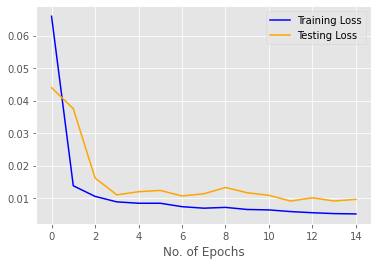

In [ ]:
plt.plot(model.history['loss'], color = "blue")
plt.plot(model.history['val_loss'], color = "orange")
plt.legend(["Training Loss", "Testing Loss"])
plt.xlabel("No. of Epochs")
plt.show()

###Evaluate predictions for testing data

In [ ]:
y_test_org = sc.inverse_transform(y_test.reshape(-1,1))
y_test_org = y_test_org.reshape([-1,1])
predict_train = Regressor.predict(X_train)
predicted_stock_price = Regressor.predict(X_test)
predict_train = sc.inverse_transform(predict_train)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

###Actual vs Predictied Stock Price plot for LSTM-RNN

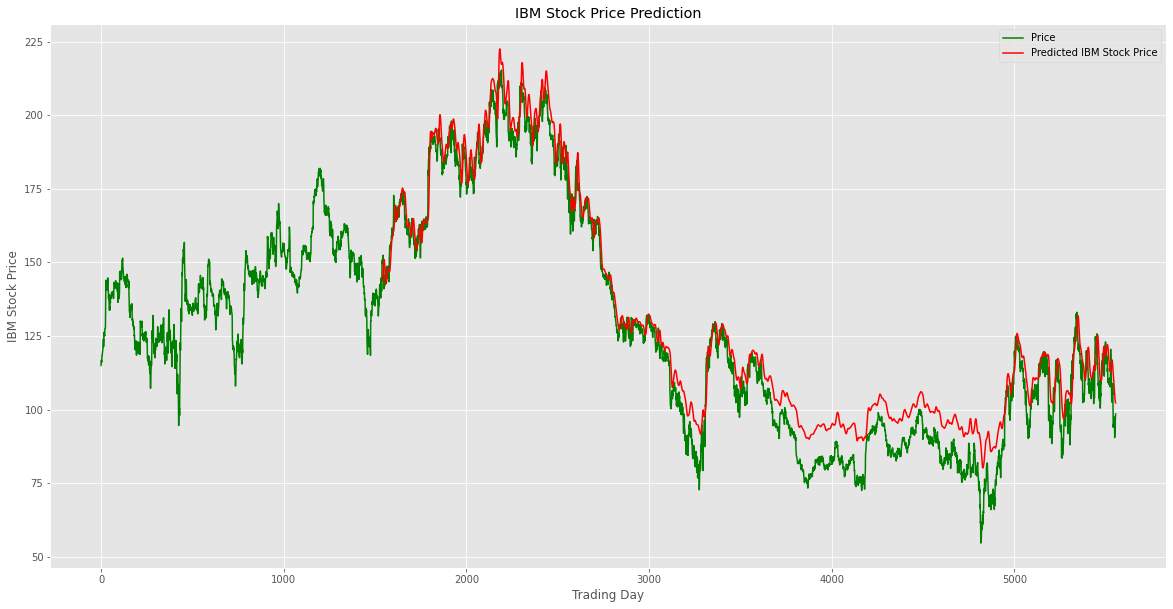

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.iloc[:,1:2].values, color = 'green', label = 'Price')
plt.plot(np.arange(train_test_partition + window_width, len(data), 1),predicted_stock_price, color = 'red', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

###Mean Squared Error for LSTM-RNN

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test_org,predicted_stock_price)

73.57105678417572

###R2 Score for LSTM-RNN

In [ ]:
from sklearn.metrics import r2_score
r2_score(predicted_stock_price,y_test_org)

0.9502953639974676

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU

In [ ]:
Regressor = Sequential()

Regressor.add(LSTM(32,return_sequences=True,input_shape=(X_train.shape[1],1)))
Regressor.add(LSTM(32,return_sequences=True))
Regressor.add(Dropout(0.3))
Regressor.add(GRU(32,return_sequences=True))
Regressor.add(Dropout(0.3))
Regressor.add(GRU(32,return_sequences=True))
Regressor.add(GRU(32))
Regressor.add(Dropout(0.2))
Regressor.add(Dense(1))

Regressor.compile(loss='mean_squared_error',optimizer='adam' , metrics = ["mse" , "mae"])

In [ ]:
Regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 32)            4352      
                                                                 
 lstm_5 (LSTM)               (None, 40, 32)            8320      
                                                                 
 dropout_4 (Dropout)         (None, 40, 32)            0         
                                                                 
 gru (GRU)                   (None, 40, 32)            6336      
                                                                 
 dropout_5 (Dropout)         (None, 40, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 40, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)               

In [ ]:
model = Regressor.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=32,verbose=1)  

Epoch 1/30
46/46 [==============================] - 16s 150ms/step - loss: 0.0503 - mse: 0.0503 - mae: 0.1632 - val_loss: 0.0652 - val_mse: 0.0652 - val_mae: 0.2309
Epoch 2/30
46/46 [==============================] - 5s 103ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0863 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0689
Epoch 3/30
46/46 [==============================] - 5s 104ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0738 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0896
Epoch 4/30
46/46 [==============================] - 5s 104ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0722 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0923
Epoch 5/30
46/46 [==============================] - 5s 104ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0698 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0709
Epoch 6/30
46/46 [==============================] - 5s 103ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0645 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0764
Epoch 7/30
46/4

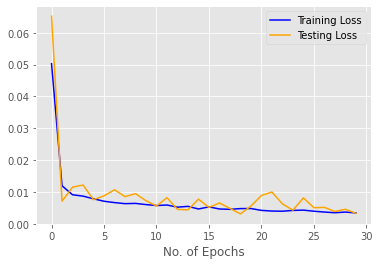

In [ ]:
plt.plot(model.history['loss'], color = "blue")
plt.plot(model.history['val_loss'], color = "orange")
plt.legend(["Training Loss", "Testing Loss"])
plt.xlabel("No. of Epochs")
plt.show()

In [ ]:
y_test_org = sc.inverse_transform(y_test.reshape(-1,1))
y_test_org = y_test_org.reshape([-1,1])
predict_train = Regressor.predict(X_train)
predicted_stock_price = Regressor.predict(X_test)
predict_train = sc.inverse_transform(predict_train)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

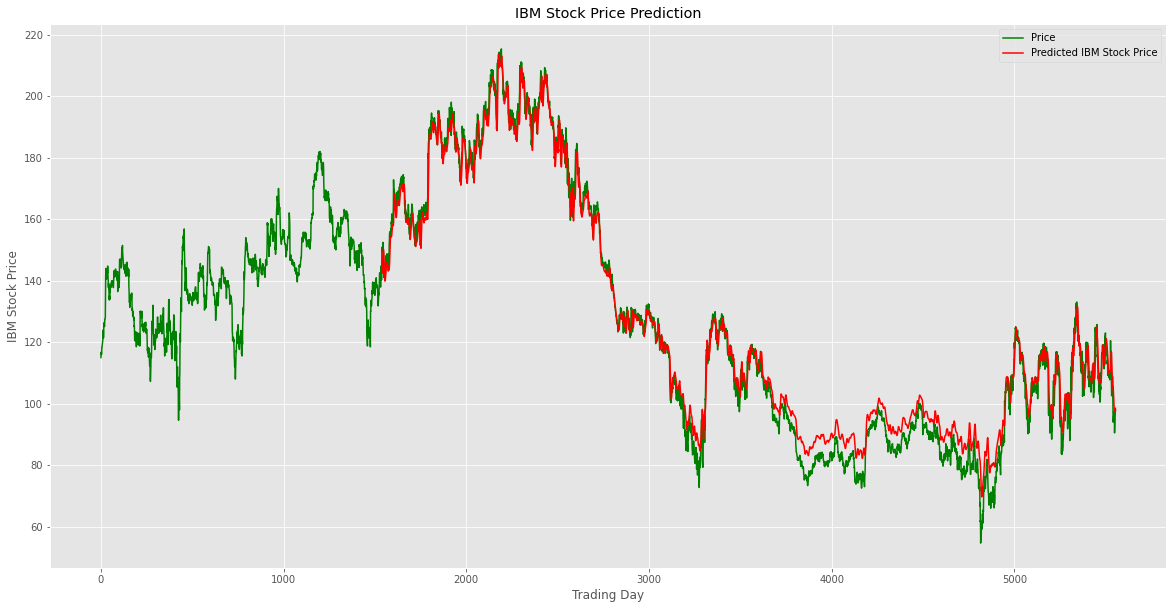

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.iloc[:,1:2].values, color = 'green', label = 'Price')
plt.plot(np.arange(train_test_partition + window_width, len(data), 1),predicted_stock_price, color = 'red', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test_org,predicted_stock_price)

25.04103073243167

In [ ]:
from sklearn.metrics import r2_score
r2_score(predicted_stock_price,y_test_org)

0.9828247096794158

In [5]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_width = 40
for i in range(len(data) - window_width):
    scaler = data.iloc[i,3]
    temp = []
    temp2 = []
    for j in range(window_width):
        temp.append((data.iloc[i + j, 1] - scaler)/scaler)
    temp2.append((data.iloc[i + window_width, 1] - scaler)/scaler)
    X.append(np.array(temp).reshape(window_width, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = train_test_partition/len(X), shuffle = False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,window_width,1)
test_X = test_X.reshape(test_X.shape[0],1,window_width,1)

print(len(train_X))
print(len(test_X))

1500
4015


In [6]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from keras.layers import MaxPooling1D, Flatten
from keras.regularizers import L1, L2
from keras.metrics import Accuracy
from keras.metrics import RootMeanSquaredError

Regressor = Sequential()

Regressor.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, window_width, 1))))
Regressor.add(TimeDistributed(MaxPooling1D(2)))
Regressor.add(Dropout(0.1))
Regressor.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
Regressor.add(TimeDistributed(MaxPooling1D(2)))
Regressor.add(Dropout(0.1))
Regressor.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
Regressor.add(TimeDistributed(MaxPooling1D(2)))
Regressor.add(Dropout(0.1))
Regressor.add(TimeDistributed(Flatten()))
Regressor.add(Dense(5, kernel_regularizer=L2(0.01)))

Regressor.add(Bidirectional(LSTM(100, return_sequences=True)))
Regressor.add(Dropout(0.5))
Regressor.add(Bidirectional(LSTM(100, return_sequences=False)))
Regressor.add(Dropout(0.5))

Regressor.add(Dense(1, activation='linear'))
Regressor.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

model = Regressor.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=20,batch_size=40, verbose=1, shuffle =True)

Epoch 1/20
38/38 [==============================] - 19s 67ms/step - loss: 0.0770 - mse: 0.0065 - mae: 0.0569 - val_loss: 0.0517 - val_mse: 0.0041 - val_mae: 0.0448
Epoch 2/20
38/38 [==============================] - 1s 22ms/step - loss: 0.0365 - mse: 0.0026 - mae: 0.0376 - val_loss: 0.0247 - val_mse: 0.0025 - val_mae: 0.0359
Epoch 3/20
38/38 [==============================] - 1s 21ms/step - loss: 0.0174 - mse: 0.0020 - mae: 0.0329 - val_loss: 0.0119 - val_mse: 0.0021 - val_mae: 0.0326
Epoch 4/20
38/38 [==============================] - 1s 20ms/step - loss: 0.0085 - mse: 0.0018 - mae: 0.0319 - val_loss: 0.0061 - val_mse: 0.0019 - val_mae: 0.0308
Epoch 5/20
38/38 [==============================] - 1s 21ms/step - loss: 0.0044 - mse: 0.0015 - mae: 0.0296 - val_loss: 0.0035 - val_mse: 0.0018 - val_mae: 0.0306
Epoch 6/20
38/38 [==============================] - 1s 27ms/step - loss: 0.0031 - mse: 0.0019 - mae: 0.0332 - val_loss: 0.0027 - val_mse: 0.0019 - val_mae: 0.0308
Epoch 7/20
38/38 [===

In [7]:
Regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 38, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 19, 64)        0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 1, 19, 64)         0         
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 17, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 8, 128)        0         
 tributed)                                              

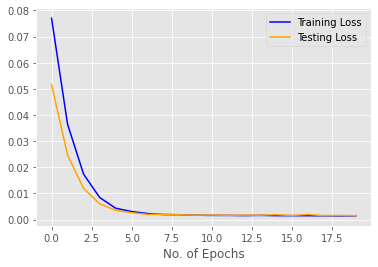

In [8]:
plt.plot(model.history['loss'], color = "blue")
plt.plot(model.history['val_loss'], color = "orange")
plt.legend(["Training Loss", "Testing Loss"])
plt.xlabel("No. of Epochs")
plt.show()

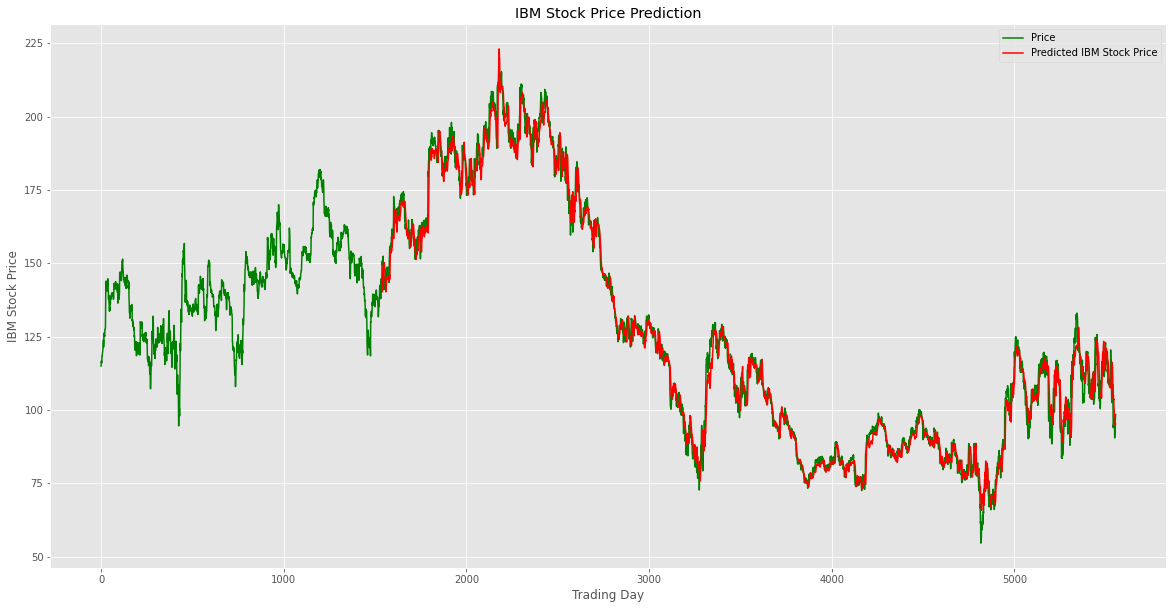

In [9]:
predicted  = Regressor.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    unscaler = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t]*unscaler + unscaler
    predicted[j - len_t] = predicted[j - len_t]*unscaler + unscaler
plt.figure(figsize=(20,10))
plt.plot(data.iloc[:,1:2].values, color = 'green', label = 'Price')
plt.plot(np.arange(train_test_partition + window_width, len(data), 1), predicted, color = 'red', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error as mse
mse(predicted,test_label)

16.899505308169793

In [10]:
from sklearn.metrics import r2_score
r2_score(predicted,test_label)

0.9898155243279891